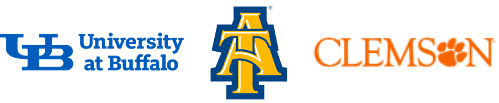

# Lab 1: Cyberbullying Detection Using AI

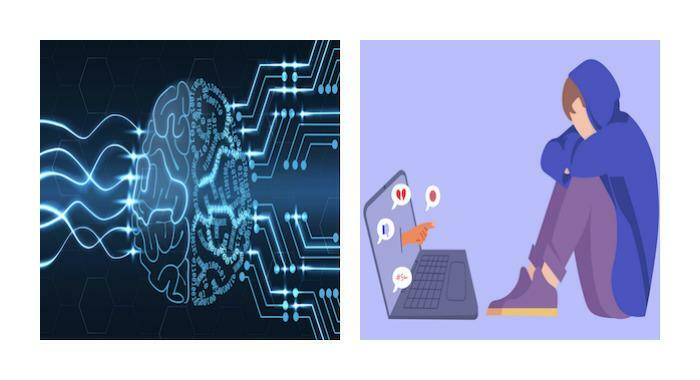

In this lab, we will learn how AI can be developed to detect cyberbullying. We will use a publicly available dataset of cyberbullying texts, and train an AI model on this dataset to automatically detect cyberbullying text. You will learn:

1. AI development process
2. Train and test your own AI for cyberbullying detection
3. Run AI on your own samples

First, we need to download softwares used in the lab. Just hit the 'play' button run the code below.

### Preliminaries

In [ ]:
# change the output font size
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style> 
    body {
      font-size: 20px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!git clone https://github.com/nishantvishwamitra/CyberbullyingLab1.git

Next, we install Pytorch, a framework for training and deploying AI technologies.

In [ ]:
!pip install conda
!conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [ ]:
!pip install torchtext==0.11.0

In [ ]:
# the pretrained embeddings
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# !wget https://github.com/cuadvancelab/materials/blob/main/lab1/glove.6B.300d.txt?raw=true
!wget https://buffalo.box.com/shared/static/fvw1q3ezopvas8sis9jaijoww4z4dpta.txt

Let's import all our softwares dependencies in our iPython notebook

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234
import pandas as pd
import numpy as np
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext

import nltk
import random
from sklearn.metrics import classification_report
import spacy
from CyberbullyingLab1.models import LSTM
from tqdm import tqdm

In [ ]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

### Data Preprocessing

In [ ]:
# @title Dowload the cyberbullying speech dataset
#Let's dowload the main dataset frist
main_df = pd.read_csv('CyberbullyingLab1/formspring_dataset.csv', sep = '\t')

# Let's see how many smaples we have
print('Total number of samples:', main_df.shape)
main_df = main_df.sample(n = main_df.shape[0])
main_df = main_df[['text', 'label']]

# Let's take a look at a few samples from our dataset
print(main_df.sample(7))

# Let's take a look at the cyberbullying labels
#print(main_df.label.value_counts())

Note:
* 0 indicates non-cyberbullying
* 1 indicates cyberbullying

While training AI, datasets are divided into three parts: training dataset, testing dataset and validation dataset. Let's create these three parts for our dataset.

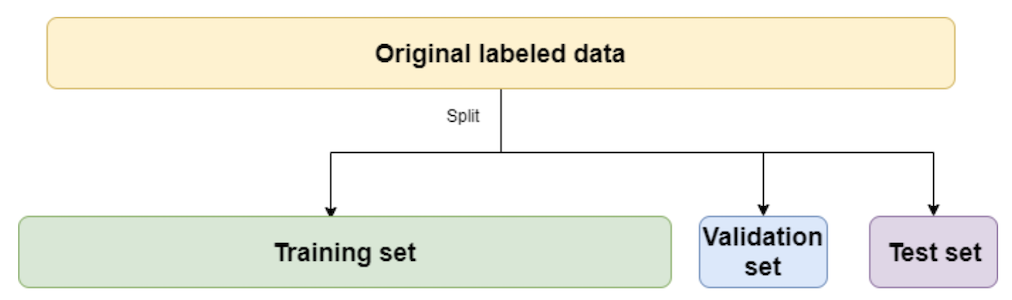

In [ ]:
# @title Let's split the datatest
# let's divide the dataset into non-cyberbullying and cyberbullying samples
o_class = main_df.loc[main_df.label == 0, :]
l_class = main_df.loc[main_df.label == 1, :]

# let's create train, val and test splits
train_val = main_df.iloc[:int(main_df.shape[0] * .80)]
test = main_df.iloc[int(main_df.shape[0] * .80):]
train = train_val.iloc[:int(train_val.shape[0] * .80)]
val = train_val.iloc[int(train_val.shape[0] * .80):]

#print(train.shape, val.shape, test.shape)

print('\nTraining set:\n', train.label.value_counts())
print('\nValidation set:\n', val.label.value_counts())
print('\nTest set:\n', test.label.value_counts())

train.to_csv("CyberbullyingLab1/dataset/train.csv", index = False)
test.to_csv("CyberbullyingLab1/dataset/test.csv", index = False)
val.to_csv("CyberbullyingLab1/dataset/valid.csv", index = False)


The first step in natural language processing for AI is tokenization. In this process, we split the text into 'tokens', that are then given unique numbers that are understood by a machine. Take a look at the example below.

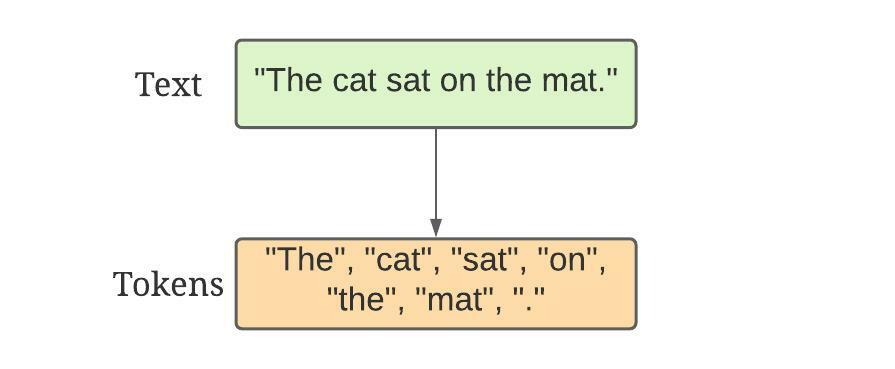

In [ ]:
# @title Let's use a tokenizer. This is the first step in NLP. 
#@markdown ### Input any sentence and run this cell to get its tokens.
spacy_en = spacy.load('en_core_web_sm')
My_Sentence = "the cat sat on the mat." #@param {type:"string"}
My_Sentence = spacy_en(My_Sentence)
print("The tokens are:")
for token in My_Sentence:
  print(token.text)

In [ ]:
# @title Loading train, test and validation data  that we prepared.
TEXT = data.Field(sequential = True, tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.long, sequential = False)
train_data, valid_data, test_data = data.TabularDataset.splits(
  path = "CyberbullyingLab1/dataset/", train = "train.csv",
  validation = "valid.csv", test = "test.csv", format = "csv", skip_header = True,
  fields=[('Text', TEXT), ('Label', LABEL)]
)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

In [ ]:
TEXT.build_vocab(train_data, vectors = torchtext.vocab.Vectors('fvw1q3ezopvas8sis9jaijoww4z4dpta.txt'), max_size = 20000, min_freq = 10)
LABEL.build_vocab(train_data)
# @title Let's see how many unique tokens in our dataset
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

In [ ]:
# @title We prepare our data with many batches to save the training time. 
BATCH_SIZE = 20
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
  (train_data, valid_data, test_data), sort_key=lambda x: len(x.Text),
  batch_size=BATCH_SIZE,
  device=device)
print(f"We prepared {BATCH_SIZE} batches accordingly")

### AI Model Definition

In [ ]:
# @title Let's instantiate our AI model.
# hyperparameters
# @title Let's define some hyperparameters for our AI model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
# You can try with different hidden dimentions
HIDDEN_DIM = 374
OUTPUT_DIM = 2

# load the model
model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
print("AI model initialized")

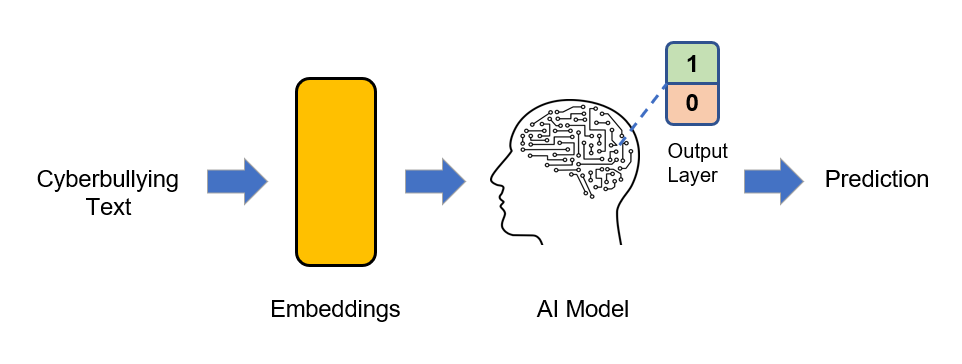

In [ ]:
# @title We will use the pretrained embeddings that we downlaoded in our model.
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data = pretrained_embeddings.to(device)

In [ ]:
# @title Define some functions for model training

# Let's define an optimizer and a loss function for training our AI
class_weights = torch.tensor([1.0, 14.0]).to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights)

model = model.to(device)
criterion = criterion.to(device)

# Let's define the training and testing procedures for our AI model
def binary_accuracy(preds, y):
  preds, ind= torch.max(F.softmax(preds, dim=-1), 1)
  correct = (ind == y).float()
  acc = correct.sum()/float(len(correct))
  return acc

# Lets define our training steps
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for batch in tqdm(iterator):

    optimizer.zero_grad()

    predictions = model(batch.Text).squeeze(0)
    loss = criterion(predictions, batch.Label)
    acc = binary_accuracy(predictions, batch.Label)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    for batch in tqdm(iterator):

      predictions = model(batch.Text).squeeze(0)

      loss = criterion(predictions, batch.Label)

      acc = binary_accuracy(predictions, batch.Label)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


Let's begin training our AI model

### Training Process

In [ ]:
# @title Let's train an AI model now!
# @markdown ### Set the number of Epochs you want to train the model, then run this cell to train our AI.
N_EPOCHS = 15 # @param {type:"integer"}

for epoch in range(N_EPOCHS):

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

  print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')


Now that our AI is trained, we can use it to detect cyberbullying in user inputted text. <br>In the cell below, try changing the samples to your own cyberbullyign text and see if our AI is able to detect your inputs as cyberbullying. 

### Deployment

In [ ]:
# @title define a function for evaluation
def predict_cb(sentence):
  tokenized = [tok for tok in sentence.split()]
  indexed = [TEXT.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed).to(device)

  tensor = tensor.unsqueeze(1)
  prediction = model(tensor)
  preds, ind= torch.max(F.softmax(prediction.squeeze(0), dim=-1), 1)
  if ind.item() == 1:
    return preds, ind, 'Cyberbullying detected.'
  else:
    return preds, ind, 'Cyberbullying not detected.'

In [ ]:
# @title Let's try with several sample sentences to check our AI's performance

# @markdown Sample 1: "You guys are a bunch of losers, so get lost"
text = 'you guys are a bunch of losers, so get lost'
ret = predict_cb(text)
print("Sample 1 prediction: ", ret[2], f'Confidence: {ret[0].item() * 100:.2f}%')

# @markdown Sample 2: "I'm never going to see your little pathetic self again"
text = 'im never going to see your little pathetic self again'
ret = predict_cb(text)
print("Sample 2 prediction: ", ret[2], f'Confidence: {ret[0].item() * 100:.2f}%')

# @markdown Sample 3: "Hello World!"
text = 'hello world!'
ret = predict_cb(text)
print("Sample 3 prediction: ", ret[2], f'Confidence: {ret[0].item() * 100:.2f}%')


### You can also test with your own sentence

In [ ]:
#@title My inputs

testing_sentence = "Let's test the AI with any sentence here!" #@param {type:"string"}
my_label = 'Non-cyberbully' #@param ["Cyberbully", "Non-cyberbully"]
pred = predict_cb(testing_sentence)


In [ ]:
#@title AI's prediction
print("AI prediction: ", pred[2], f'Confidence: {pred[0].item() * 100:.2f}%')